# 1. Install Necessary Libraries

In [1]:
%%capture --no-stderr
%pip install -U --quiet langchain-community tiktoken langchain-openai langchainhub chromadb langchain langgraph langchain-text-splitters beautifulsoup4

# 2. Import necessary dependencies and set environment variables

In [2]:
import getpass
import os


def _set_env(key: str):
    if key not in os.environ:
        os.environ[key] = getpass.getpass(f"{key}:")


_set_env("OPENAI_API_KEY")

OPENAI_API_KEY:··········


In [ ]:
llm = ChatOpenAI(model="gpt-4o-mini")

# RAG

Large Language Models (LLMs) have demonstrated impressive capabilities in generating human-like text, but they are limited by the data they were trained on. This is where Retrieval Augmented Generation (RAG) comes in. RAG enhances LLMs by allowing them to access and incorporate external knowledge sources, leading to more accurate, relevant, and grounded responses. This blog post will explore the four core areas of RAG: Indexing & Embedding, Retrieval, Augmentation through Prompting, and Generation.

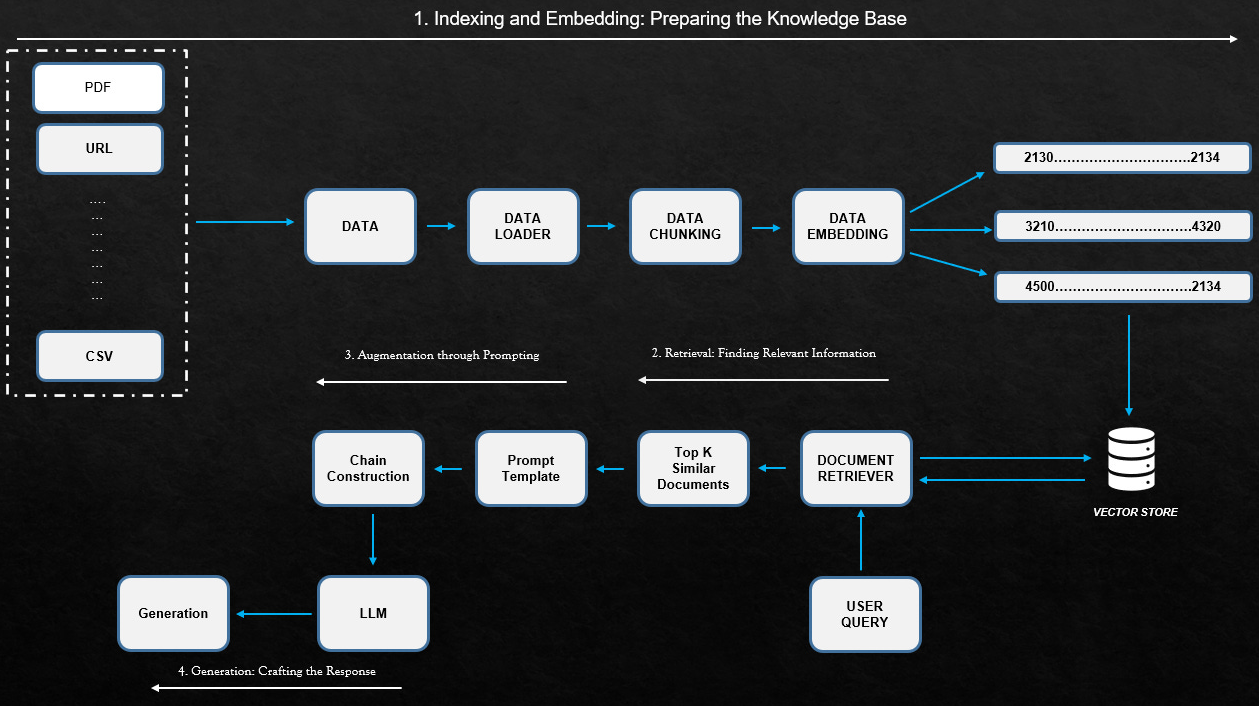

Detailed Blog :  https://aiproductplaybook.substack.com/p/2-rag-high-level-design

# 3. Agentic RAG

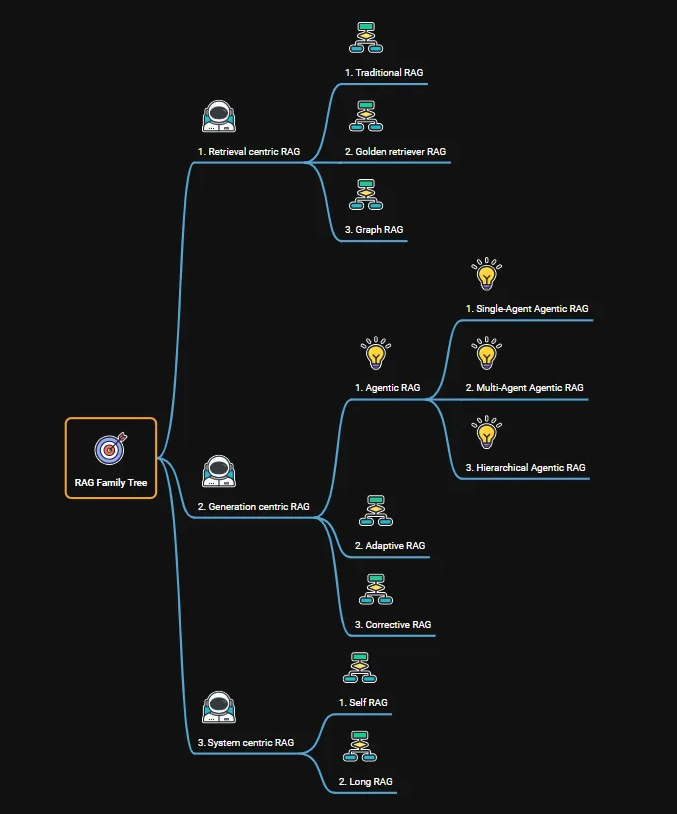

Detailed Blog : https://aiproductplaybook.substack.com/p/85-what-the-heck-are-agentic-rags

### a. Agentic RAG

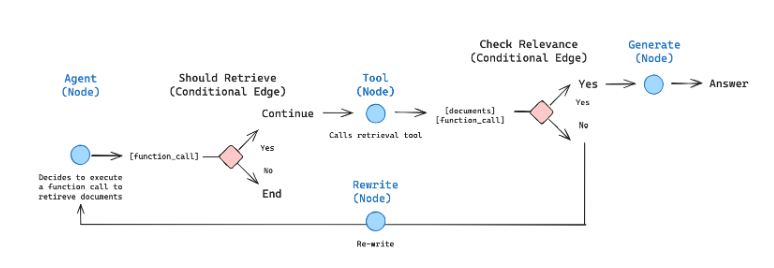

### b. Index the Knowledge Base

1. Import necessary dependencies

2. URLs : This list contains the URLs of the web pages you want to load.

3. Loading Web Pages

a. docs = [WebBaseLoader(url).load() for url in urls]: This uses a list comprehension to load the content of each URL using WebBaseLoader. The result is a list of lists, where each inner list contains the documents loaded from a single URL.

b. docs_list = [item for sublist in docs for item in sublist]: This flattens the list of lists into a single list of documents.

4. Text Splitting

a. text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(...): Creates a RecursiveCharacterTextSplitter object. This splitter recursively breaks down the text into chunks.

chunk_size=100: Specifies that each chunk should ideally be around 100 characters long.

chunk_overlap=50: Specifies that there should be a 50-character overlap between consecutive chunks. This helps preserve context across chunks.

from_tiktoken_encoder: This is an efficient way to count tokens, ensuring that chunks are split based on token count (which is more relevant for LLMs) rather than just character count. It requires the tiktoken library to be installed.

b. doc_splits = text_splitter.split_documents(docs_list): Splits the loaded documents into chunks using the configured text splitter.

5. Creating the Vector Database

a. vectorstore = Chroma.from_documents(...): Creates a Chroma vector database from the document chunks.

documents=doc_splits: Provides the list of document chunks.

collection_name="rag-chroma": Gives a name to the Chroma collection.

embedding=OpenAIEmbeddings(): Specifies that OpenAI's embeddings model should be used to create vector representations of the text chunks. This requires an OpenAI API key to be set as an environment variable (OPENAI_API_KEY).

b. retriever = vectorstore.as_retriever(): Creates a retriever object from the vector database. The retriever is used to fetch relevant chunks of text based on a query.

Summary

This code loads web pages, splits them into smaller, overlapping chunks using a tiktoken aware splitter, and then creates a Chroma vector database from these chunks.  It uses OpenAI embeddings to create vector representations of the text, which are stored in the vector database.  Finally, it creates a retriever, which can be used to efficiently retrieve relevant context from the documents based on a user's query. This setup is essential for building RAG applications, where relevant information is retrieved from a knowledge base to augment the capabilities of a large language model.

In [3]:
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
    "https://lilianweng.github.io/posts/2023-10-25-adv-attack-llm/",
]

docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=100, chunk_overlap=50
)
doc_splits = text_splitter.split_documents(docs_list)

# Add to vectorDB
vectorstore = Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)
retriever = vectorstore.as_retriever()

### c. Define the retriever tool

1. Import necessary dependencies

2. Creating the Retriever Tool

a. create_retriever_tool(retriever, "retrieve_blog_posts", "..."): This function creates the tool. It takes three arguments:

retriever: The retriever object (created in the previous code snippet). This is the object that will actually perform the search.

"retrieve_blog_posts": The name of the tool. This is how the agent will refer to the tool. It should be descriptive.

"Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.": A description of the tool. This is important for the LLM to understand how to use the tool. It should clearly explain the tool's purpose and capabilities.

3. Creating the Tools List

This line creates a list called tools and adds the retriever_tool to it. In LangChain, agents use lists of tools. Even if you only have one tool, it needs to be in a list.

summary

This code takes a retriever (which was created from a vector database in the previous code) and converts it into a LangChain tool. The tool is named "retrieve_blog_posts" and has a description that explains its purpose.  The tool is then added to a list called tools. This list can then be passed to a LangChain agent, allowing the agent to use the retriever to search for information within the indexed blog posts.  The agent can then use the search results in its responses or to inform further actions.

In [5]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]

### d. Define the Agent state

The AgentState TypedDict defines the structure of the agent's state.  It specifically indicates that the messages field should contain a sequence of BaseMessage objects (the conversation history) and, importantly, that new messages should be appended to this sequence rather than replacing it.  This is achieved using the Annotated type hint with the add_messages function.  This ensures that the agent keeps track of the entire conversation history, which is crucial for most conversational agents.

In [6]:
from typing import Annotated, Sequence
from typing_extensions import TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph.message import add_messages


class AgentState(TypedDict):
    # The add_messages function defines how an update should be processed
    # Default is to replace. add_messages says "append"
    messages: Annotated[Sequence[BaseMessage], add_messages]

### e. Define the Nodes and Edges

1. Import necessary dependencies

2. grade_documents(state) Function

This function determines if the retrieved documents are relevant to the user's question.

Logic:

a. Prints a message: print("---CHECK RELEVANCE---") for debugging.

b. Defines a Pydantic model grade: This model has a single field, binary_score, which can be "yes" or "no". This is used to structure the output of the relevance check LLM.

c. Initializes the LLM: model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True) Sets up the LLM for the relevance check.

d. Binds the output schema: llm_with_tool = model.with_structured_output(grade) Tells the LLM to structure its output according to the grade model.

e. Creates a prompt: The PromptTemplate instructs the LLM to assess the relevance of the document to the question and provide a "yes" or "no" score.

f. Creates a chain: chain = prompt | llm_with_tool chains the prompt and the LLM together.

g. Extracts question and documents: Gets the question from the first message in the state and the retrieved documents from the last message.

h. Invokes the chain: scored_result = chain.invoke(...) runs the relevance check.

Checks the score:

If score == "yes": The function returns "generate", indicating that the next step should be to generate the answer.

If score == "no": The function returns "rewrite", indicating that the next step should be to rewrite the question.

3. agent(state) Function

This function is the main agent logic. It takes the current state and uses the LLM to decide whether to retrieve or end.

Logic:

a. Prints a message: print("---CALL AGENT---")

b. Initializes the LLM: Sets up the LLM with tools bound.

c. Invokes the LLM: Runs the LLM with the current message history.

d. Returns updated state: Returns the state with the LLM's response appended to the messages.

4. rewrite(state) Function

This function rewrites the user's question to improve retrieval effectiveness.

Logic:

a. Prints a message: print("---TRANSFORM QUERY---")

b. Extracts the question: Gets the original question from the message history.

c. Creates a prompt: Asks the LLM to rephrase the question semantically.

d. Initializes the LLM: Sets up the LLM for query rewriting.

e. Invokes the LLM: Runs the LLM with the prompt.

f. Returns updated state: Returns the state with the rephrased question.

5. generate(state) Function

This function generates the final answer using the retrieved documents and the question.

Logic:

a. Prints a message: print("---GENERATE---")

b. Extracts question and documents: Gets the question and retrieved documents from the state.

c. Loads the RAG prompt: prompt = hub.pull("rlm/rag-prompt") Loads a pre-built RAG prompt from the LangChain Hub.

d. Initializes the LLM: Sets up the LLM for answer generation.

e. Defines a document formatter: format_docs joins the document content.

f. Creates the RAG chain: rag_chain = prompt | llm | StrOutputParser() chains the prompt, LLM, and output parser.

g. Invokes the chain: Runs the RAG chain to generate the answer.

h. Returns updated state: Returns the state with the generated answer.

6. Prompt Display

Summary

This code defines a LangChain graph for a RAG-based QA system with relevance checking and query rewriting. The grade_documents function decides whether documents are relevant.  The agent function decides whether to retrieve or end. The rewrite function improves the question. The generate function creates the final answer. The graph orchestrates these functions to provide a more robust and accurate QA system.  The use of pre-built prompts from the Hub simplifies development.

In [7]:
from typing import Annotated, Literal, Sequence
from typing_extensions import TypedDict

from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

from pydantic import BaseModel, Field


from langgraph.prebuilt import tools_condition

### Edges


def grade_documents(state) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (messages): The current state

    Returns:
        str: A decision for whether the documents are relevant or not
    """

    print("---CHECK RELEVANCE---")

    # Data model
    class grade(BaseModel):
        """Binary score for relevance check."""

        binary_score: str = Field(description="Relevance score 'yes' or 'no'")

    # LLM
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)

    # LLM with tool and validation
    llm_with_tool = model.with_structured_output(grade)

    # Prompt
    prompt = PromptTemplate(
        template="""You are a grader assessing relevance of a retrieved document to a user question. \n
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the document contains keyword(s) or semantic meaning related to the user question, grade it as relevant. \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.""",
        input_variables=["context", "question"],
    )

    # Chain
    chain = prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"


### Nodes


def agent(state):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with the agent response appended to messages
    """
    print("---CALL AGENT---")
    messages = state["messages"]
    model = ChatOpenAI(temperature=0, streaming=True, model="gpt-4o-mini")
    model = model.bind_tools(tools)
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n
    Look at the input and try to reason about the underlying semantic intent / meaning. \n
    Here is the initial question:
    \n ------- \n
    {question}
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4o-mini", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}


def generate(state):
    """
    Generate answer

    Args:
        state (messages): The current state

    Returns:
         dict: The updated state with re-phrased question
    """
    print("---GENERATE---")
    messages = state["messages"]
    question = messages[0].content
    last_message = messages[-1]

    docs = last_message.content

    # Prompt
    prompt = hub.pull("rlm/rag-prompt")

    # LLM
    llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0, streaming=True)

    # Post-processing
    def format_docs(docs):
        return "\n\n".join(doc.page_content for doc in docs)

    # Chain
    rag_chain = prompt | llm | StrOutputParser()

    # Run
    response = rag_chain.invoke({"context": docs, "question": question})
    return {"messages": [response]}


print("*" * 20 + "Prompt[rlm/rag-prompt]" + "*" * 20)
prompt = hub.pull("rlm/rag-prompt").pretty_print()  # Show what the prompt looks like

********************Prompt[rlm/rag-prompt]********************
================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


### f. Define the Graph and visualize it

In [8]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

# Define a new graph
workflow = StateGraph(AgentState)

# Define the nodes we will cycle between
workflow.add_node("agent", agent)  # agent
retrieve = ToolNode([retriever_tool])
workflow.add_node("retrieve", retrieve)  # retrieval
workflow.add_node("rewrite", rewrite)  # Re-writing the question
workflow.add_node(
    "generate", generate
)  # Generating a response after we know the documents are relevant
# Call agent node to decide to retrieve or not
workflow.add_edge(START, "agent")

# Decide whether to retrieve
workflow.add_conditional_edges(
    "agent",
    # Assess agent decision
    tools_condition,
    {
        # Translate the condition outputs to nodes in our graph
        "tools": "retrieve",
        END: END,
    },
)

# Edges taken after the `action` node is called.
workflow.add_conditional_edges(
    "retrieve",
    # Assess agent decision
    grade_documents,
)
workflow.add_edge("generate", END)
workflow.add_edge("rewrite", "agent")

# Compile
graph = workflow.compile()

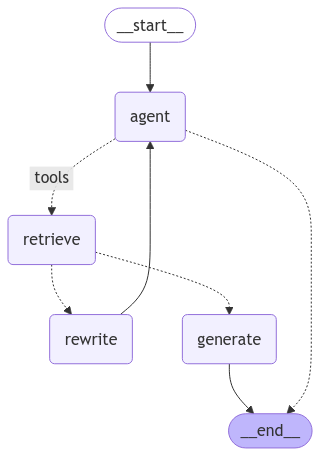

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### g. Invoke the RAG

In [10]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about the types of agent memory?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_Mb1tI7yvgVQzJqUKIOzmCc92', 'function': {'arguments': '{"query":"types of agent memory"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1'}, id='run-95cf0ffb-892d-4e65-9cdf-bdcdc413ff7f-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'types of agent memory'}, 'id': 'call_Mb1tI7yvgVQzJqUKIOzmCc92', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS RELEVANT---
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='Table of Contents\n\n\n\nAgent System Overview\n\nComponent One: Planning\n\nTask Decomposition\n\nSelf-Reflection\n\n\nComponent Two: Memory\n\nTypes of Memory\n\nMaximum Inner Product Search (MIPS)\n\n\nComponent Three: Tool Use\n\nCase S

/usr/local/lib/python3.11/dist-packages/langsmith/client.py:253: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


"Output from node 'generate':"
'---'
{ 'messages': [ 'Lilian Weng discusses two types of agent memory: short-term '
                'memory, which involves in-context learning for immediate '
                'tasks, and long-term memory, which allows agents to retain '
                'and recall information over extended periods using external '
                "storage. This dual memory system enhances the agent's ability "
                'to learn from past experiences and improve future '
                'performance.']}
'\n---\n'


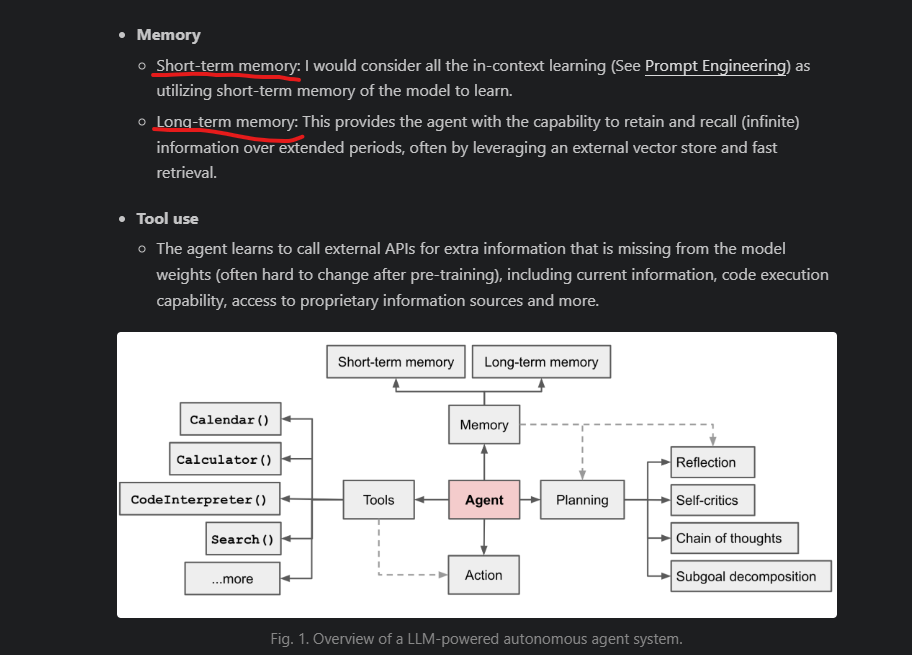

In [12]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about different types of Task Decomposition?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_l8GmouCloAC8ggPgI6FeL2Fu', 'function': {'arguments': '{"query":"Task Decomposition"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1'}, id='run-865c51da-4b56-46c2-af1b-0b109b9802bc-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Task Decomposition'}, 'id': 'call_l8GmouCloAC8ggPgI6FeL2Fu', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='Task Decomposition#\nChain of thought (CoT; Wei et al. 2022) has become a standard prompting technique for enhancing model performance on complex tasks. The model is instructed to “think step by step” to utilize more test-time computation 

In [13]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about Self Reflection ?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_iM9GcGEyQM59yvz0nRfaAjsq', 'function': {'arguments': '{"query":"Self Reflection"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a'}, id='run-6a3b8d5c-f710-4953-91ba-3959043176e2-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Self Reflection'}, 'id': 'call_iM9GcGEyQM59yvz0nRfaAjsq', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='Self-Reflection#\nSelf-reflection is a vital aspect that allows autonomous agents to improve iteratively by refining past action decisions and correcting previous mistakes. It plays a crucial role in real-world tasks where trial and error are in

In [14]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about types of CoT prompts ?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_eUrsnj35lI0jDeale6QTIZc0', 'function': {'arguments': '{"query":"types of CoT prompts"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a'}, id='run-a44d0afc-fe45-4253-bd1f-b5ac6f7aa336-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'types of CoT prompts'}, 'id': 'call_eUrsnj35lI0jDeale6QTIZc0', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='Types of CoT prompts#\nTwo main types of CoT prompting:\n\nChain-of-Thought (CoT)\n\nTypes of CoT prompts\n\nTips and Extensions\n\n\nAutomatic Prompt Design\n\nAugmented Language Models\n\nRetrieval\n\nProgramming Language\n\nExternal

In [15]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about Tree of Thoughts ?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_yiCcTdQaKh4gZQKmODbQWres', 'function': {'arguments': '{"query":"Tree of Thoughts"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_00428b782a'}, id='run-a3064302-faba-4b6d-b860-d90c056c9326-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Tree of Thoughts'}, 'id': 'call_yiCcTdQaKh4gZQKmODbQWres', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='Tree of Thoughts (Yao et al. 2023) extends CoT by exploring multiple reasoning possibilities at each step. It first decomposes the problem into multiple thought steps and generates multiple thoughts per step, creating a tree structure. The sea

In [18]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about White-box vs Black-box attacks ?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_HdlBX8rHmL5OGWB6ENwAlJuJ', 'function': {'arguments': '{"query":"White-box vs Black-box attacks"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1'}, id='run-d793ef9f-f473-4625-8b06-d93aac620855-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'White-box vs Black-box attacks'}, 'id': 'call_HdlBX8rHmL5OGWB6ENwAlJuJ', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='White-box vs Black-box#\nWhite-box attacks assume that attackers have full access to the model weights, architecture and training pipeline, such that attackers can obtain gradient signals. We don’t assume attackers 

In [19]:
import pprint

inputs = {
    "messages": [
        ("user", "What does Lilian Weng say about Jailbreak prompting ?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint("---")
        pprint.pprint(value, indent=2, width=80, depth=None)
    pprint.pprint("\n---\n")

---CALL AGENT---
"Output from node 'agent':"
'---'
{ 'messages': [ AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_7alqbMiATO47Y7eDfydHeiBf', 'function': {'arguments': '{"query":"Jailbreak prompting"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_13eed4fce1'}, id='run-d7d2433d-56c0-4c1b-b322-59739f6a4000-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Jailbreak prompting'}, 'id': 'call_7alqbMiATO47Y7eDfydHeiBf', 'type': 'tool_call'}])]}
'\n---\n'
---CHECK RELEVANCE---
---DECISION: DOCS NOT RELEVANT---
no
"Output from node 'retrieve':"
'---'
{ 'messages': [ ToolMessage(content='Jailbreak Prompting#\nJailbreak prompts adversarially trigger LLMs to output harmful content that should have been mitigated. Jailbreaks are black-box attacks and thus the wording combinations are based on heuristic and manual exploratio